1. Importing Data

In [27]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_selection import chi2, RFE
from sklearn.svm import SVR

In [28]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [29]:
X = data.iloc[:, :-1].values
y= data.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 24)

2. Feature Selection

In [30]:
feature_names =data.iloc[:,:-1].columns.tolist()

2.1 Filter Based - Chi2

In [5]:
# Runtime: 0.2s

# Scale features to [0,1] because chi2 needs non-negative data
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)

chi2_stats, p_values = chi2(X_train_minmax, y_train)

feature_dict={}

for feature, (name, score) in enumerate(zip(feature_names, p_values)):
    feature_dict[name]=score

from collections import OrderedDict
sorted_dict = OrderedDict(sorted(feature_dict.items(), key=lambda item: item[1],reverse=False))

print("Sorted feature importance based on Chi Squared Sampling with p-value < 0.05")

for key, value in sorted_dict.items():
    if(value < 0.05):
        print(key, value)


Sorted feature importance based on Chi Squared Sampling with p-value < 0.05
V11 6.857346285969892e-18
V4 3.2466106406626534e-15
V14 5.33468861116989e-09
V12 2.209593337218608e-08
V17 4.057242893927253e-06
V16 5.065075375448827e-06
V18 0.00019504112624765536
V3 0.00035113655296078094
V10 0.0013208361987978826
V9 0.010453046661029556
Time 0.016809308099405097


2.2 Wrapper Based - RFE

In [ ]:
# Runtime: 9249m 41.2s

estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=10, step=1)
selector = selector.fit(X_train, y_train)

print(selector.support_)
print(selector.ranking_)

2.3 Embedded - Lasso

In [41]:
from sklearn.linear_model import Lasso
from collections import OrderedDict

# Initializing the Model
lasso = Lasso(1e-5)

# GridSearchCV with model, params and folds.
lasso.fit(X_train, y_train)

feature_dict={}

for feature, (name, score) in enumerate(zip(feature_names, np.abs(lasso.coef_))):
    feature_dict[name]=score

sorted_dict = OrderedDict(sorted(feature_dict.items(), key=lambda item: item[1],reverse=True))

print("Sorted feature importance based on Lasso Sampling with > 0.001 importance")
for key, value in sorted_dict.items():
    if(value > 0.001):
        print(key, value)

Sorted feature importance based on Lasso Sampling with > 0.001 importance
V17 0.016004886299267197
V14 0.013116125436766254
V12 0.010802915286500138
V16 0.009264501783026992
V10 0.008034661364155177
V7 0.00701496519265991
V11 0.006234458212765289
V18 0.005620237052908439
V3 0.005010061281942614
V4 0.0037168974421158602
V9 0.0035992936574496225
V2 0.003020923363284476
V5 0.002209454645264749
V21 0.0020169963587593725
V1 0.0018854377982463792
V19 0.0018367702201415531
V6 0.0016840576219361047
V27 0.0014736049806057577
V28 0.0010666184125419354


In [31]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

def modelAnalyzer(X_train, X_test, y_train, y_test):
    svc = SVC(random_state = 24)
    lgr = LogisticRegression(random_state = 24)
    mlp = MLPClassifier(random_state = 24)
    dt = DecisionTreeClassifier(random_state = 24)

    models = [svc, lgr, mlp, dt]
    model_dict={0:'SVC',1:'LogisticRegression',2:'MLPClassifier',3:'DecisionTreeClassifier'}

    results = {}

    for i,model in enumerate(models):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_train)
        f1_train=f1_score(y_train,y_pred)

        pred_test=model.predict(X_test)
        f1_test=f1_score(y_test,pred_test)

        print("{} F1 Score:".format(model_dict[i]))
        print(f"train_f1:{f1_train:.5f}")
        print(f"test_f1:{f1_test:.5f}\n")
        results[model_dict[i]] = f1_test

    return results

3.0 Get data fields

In [33]:
# Chi2 Feature Selection
# Sorted feature importance based on Chi Squared Sampling with p-value < 0.05
# V11 1.1625016088982962e-16
# V4 3.896224045410223e-15
# V14 9.55050954444407e-09
# V12 3.180737932355083e-08
# V17 1.7572094650447125e-05
# V16 0.0001696850178127307
# V18 0.00029138722000186763
# V10 0.0015501771988898833
# V3 0.009639517281485386
# V9 0.013882236970447126
# Time 0.027349413572258584

X_chi2 = data.loc[:, ['V11', 'V4', 'V14', 'V12', 'V17', 'V16', 'V18', 'V10', 'V3', 'V9', 'Time']]

X_train_chi2, X_test_chi2, y_train_chi2, y_test_chi2 = train_test_split(X_chi2,y, test_size = 0.2, random_state = 24)

chi2_f1_score = modelAnalyzer(X_train_chi2, X_test_chi2, y_train_chi2, y_test_chi2)

SVC F1 Score:
train_f1:0.00000
test_f1:0.00000



C:\Users\Joshua\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression F1 Score:
train_f1:0.70138
test_f1:0.66304

MLPClassifier F1 Score:
train_f1:0.04592
test_f1:0.01681

DecisionTreeClassifier F1 Score:
train_f1:1.00000
test_f1:0.76233



In [34]:
# RFE Feature Selection
# [False False False  True  True False False  True False  True  True False
#  False  True  True False  True  True  True False False False False False
#  False False False False False False]
# [21 13 17  1  1  9 11  1 16  1  1  4 12  1  1  8  1  1  1  2  7  3 15 18
#  19 14 10  5  6 20]

X_rfe = data.iloc[:, [3,4,7,9,10,13,14,16,17,18]]

X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(X_rfe,y, test_size = 0.2, random_state = 24)

rfe_f1_score = modelAnalyzer(X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe)

SVC F1 Score:
train_f1:0.90571
test_f1:0.80000

LogisticRegression F1 Score:
train_f1:0.72013
test_f1:0.69519

MLPClassifier F1 Score:
train_f1:0.87052
test_f1:0.80751

DecisionTreeClassifier F1 Score:
train_f1:1.00000
test_f1:0.73059



In [35]:
# Lasso Feature Selection
# Sorted feature importance based on Lasso Sampling with > 0.001 importance
# V17 0.016004886299267197
# V14 0.013116125436766254
# V12 0.010802915286500138
# V16 0.009264501783026992
# V10 0.008034661364155177
# V7 0.00701496519265991
# V11 0.006234458212765289
# V18 0.005620237052908439
# V3 0.005010061281942614
# V4 0.0037168974421158602
# V9 0.0035992936574496225
# V2 0.003020923363284476
# V5 0.002209454645264749
# V21 0.0020169963587593725
# V1 0.0018854377982463792
# V19 0.0018367702201415531
# V6 0.0016840576219361047
# V27 0.0014736049806057577
# V28 0.0010666184125419354


X_lasso = data.loc[:, ['V17', 'V14', 'V12', 'V16', 'V10', 'V7', 'V11', 'V18', 'V3', 'V4', 'V9', 'V2', 'V5', 'V21', 'V1', 'V19', 'V6', 'V27', 'V28']]

X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(X_lasso,y, test_size = 0.2, random_state = 24)

lasso_f1_score = modelAnalyzer(X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso)

SVC F1 Score:
train_f1:0.90129
test_f1:0.76531

LogisticRegression F1 Score:
train_f1:0.71384
test_f1:0.67391

MLPClassifier F1 Score:
train_f1:0.89733
test_f1:0.80583

DecisionTreeClassifier F1 Score:
train_f1:1.00000
test_f1:0.72889



In [36]:
# Majority Voting

f_dict = {}

for i,feature in enumerate(X_chi2.columns):
    f_dict[feature] = 1
for i,feature in enumerate(X_rfe.columns):
    if feature in f_dict.keys():
        f_dict[feature] += 1
for i,feature in enumerate(X_lasso.columns):
    if feature in f_dict.keys():
        f_dict[feature] += 1

majority_dict = {}
for key,value in f_dict.items():
    if value > 1:
        majority_dict[key] = value
print("Majority Vote features: ", majority_dict.keys())

X_majVote = data.loc[:, majority_dict.keys()]
X_train_majVote, X_test_majVote, y_train_majVote, y_test_majVote = train_test_split(X_majVote,y, test_size = 0.2, random_state = 24)

majority_f1_score = modelAnalyzer(X_train_majVote, X_test_majVote, y_train_majVote, y_test_majVote)

Majority Vote features:  dict_keys(['V11', 'V4', 'V14', 'V12', 'V17', 'V16', 'V18', 'V10', 'V3', 'V9'])
SVC F1 Score:
train_f1:0.90728
test_f1:0.78818

LogisticRegression F1 Score:
train_f1:0.71586
test_f1:0.68108

MLPClassifier F1 Score:
train_f1:0.84254
test_f1:0.79452

DecisionTreeClassifier F1 Score:
train_f1:1.00000
test_f1:0.73636



F1 Plot For SVC

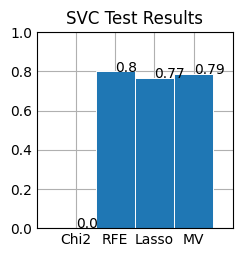

In [84]:
import matplotlib.pyplot as plt

x = ['Chi2', 'RFE', 'Lasso', 'MV']
y = [chi2_f1_score['SVC'], rfe_f1_score['SVC'], lasso_f1_score['SVC'], majority_f1_score['SVC']]

fig, ax = plt.subplots()

ax.bar(x, y, width=1, edgecolor="white", linewidth=0.7)

ax.set(xlim=(-1, 4),
       ylim=(0, 1),
       title="SVC Test Results")

for i in range(len(x)):
        plt.text(i,y[i],y[i].round(2))

plt.show()

F1 Plot for Logistic Regression

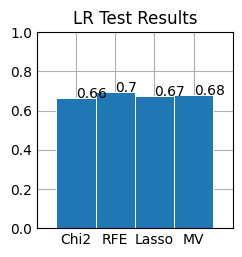

In [85]:
x = ['Chi2', 'RFE', 'Lasso', 'MV']
y = [chi2_f1_score['LogisticRegression'], rfe_f1_score['LogisticRegression'], lasso_f1_score['LogisticRegression'], majority_f1_score['LogisticRegression']]

fig, ax = plt.subplots()

ax.bar(x, y, width=1, edgecolor="white", linewidth=0.7)

ax.set(xlim=(-1, 4),
       ylim=(0, 1),
       title="LR Test Results")
for i in range(len(x)):
        plt.text(i,y[i],y[i].round(2))
plt.show()

F1 Plot for MLP Classifier

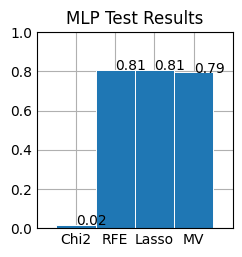

In [86]:
x = ['Chi2', 'RFE', 'Lasso', 'MV']
y = [chi2_f1_score['MLPClassifier'], rfe_f1_score['MLPClassifier'], lasso_f1_score['MLPClassifier'], majority_f1_score['MLPClassifier']]

fig, ax = plt.subplots()

ax.bar(x, y, width=1, edgecolor="white", linewidth=0.7)

ax.set(xlim=(-1, 4),
       ylim=(0, 1),
       title="MLP Test Results")
for i in range(len(x)):
        plt.text(i,y[i],y[i].round(2))
plt.show()

F1 Plot for Decision Tree

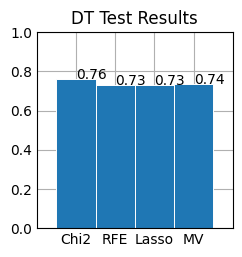

In [87]:
x = ['Chi2', 'RFE', 'Lasso', 'MV']
y = [chi2_f1_score['DecisionTreeClassifier'], rfe_f1_score['DecisionTreeClassifier'], lasso_f1_score['DecisionTreeClassifier'], majority_f1_score['DecisionTreeClassifier']]

fig, ax = plt.subplots()

ax.bar(x, y, width=1, edgecolor="white", linewidth=0.7)

ax.set(xlim=(-1, 4),
       ylim=(0, 1),
       title="DT Test Results")
for i in range(len(x)):
        plt.text(i,y[i],y[i].round(2))
plt.show()